## Загрузка даталоадеров для MNIST

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
DATA_FLATTEN_SHAPE = 784

class MNISTDataLoader:
    def __init__(self, batch_size=64, num_workers=0, subset_size=None):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        # Train dataset
        self.train_dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=True, 
            download=True, 
            transform=self.transform
        )
        
        # Test dataset
        self.test_dataset = torchvision.datasets.MNIST(
            root='./data',
            train=False,
            download=True,
            transform=self.transform
        )
        
        # Apply subset if needed
        if subset_size is not None:
            self.train_dataset = torch.utils.data.Subset(self.train_dataset, range(subset_size))
            self.test_dataset = torch.utils.data.Subset(self.test_dataset, range(subset_size))
        
        # DataLoaders
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
        
        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,  # Обычно тестовые данные не перемешивают
            num_workers=self.num_workers
        )

    def get_train_loader(self):
        return self.train_loader
    
    def get_test_loader(self):
        return self.test_loader

# Пример использования
SUBSET_SIZE = 60000
data_loader = MNISTDataLoader(batch_size=1, subset_size=SUBSET_SIZE)
test_dataloader = MNISTDataLoader(batch_size=1, subset_size=10000)




train_loader = data_loader.get_train_loader()
test_loader = test_dataloader.get_test_loader() 

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.81MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Классы метода SoftHebb для обучения популяции нейронов локальными (не градиентными) методами [https://arxiv.org/abs/2107.05747, https://arxiv.org/abs/2209.11883] и слоя нейронной сети в качестве классификатора

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

class SingleLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2000, 10)  

    def forward(self, x):
        x = x.view(-1, 2000)  
        return self.fc(x)

class Layer:
    def __init__(self, num_neuron, num_synapses, eta, base, device, lr_decay="exp", w_ch1=[], w_ch2=[], bias=[]):
        self.num_neuron = num_neuron
        self.num_synapses = num_synapses
        self.neurons = []
        self.eta = eta.reshape(-1,1).to(device)
        self.w_ch1 = w_ch1
        self.w_ch2 = w_ch2
        self.bias = bias
        self.device = device
        self.lr_decay = lr_decay
        self.eta_0 = self.eta
        self.W = (0.3*torch.randn((num_synapses, num_neuron))).to(device)
        self.y_get = []
        self.b_get = []
        self.b = torch.zeros((num_neuron,1), device = self.device)
        self.dicts = [{} for i in range(self.num_neuron)]
        self.base = base

    def get_weights(self):
        return self.W

    def get_bias(self):
        return self.b

    def get_vote(self):
        return self.dicts

    def voting_of_neurons(self, x, label):

        u = torch.zeros((self.num_neuron, 1), device=self.device)  # взвешенные суммы нейронов
        y = torch.zeros((self.num_neuron, 1), device=self.device)  # активации нейронов
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        label = label.item()
        max_activ = torch.argmax(y)  # .to("cpu").numpy() # возвращаем индекс наиболее активного нейрона
        self.dicts[max_activ][label] = self.dicts[max_activ].get(label, 0) + 1

    def get_predict(self, x):

        u = torch.zeros((self.num_neuron, 1), device=self.device)  # взвешенные суммы нейронов
        y = torch.zeros((self.num_neuron, 1), device=self.device)  # активации нейронов
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        a = torch.argmax(y)
        if (self.dicts[a]):
            label = max(self.dicts[a], key=self.dicts[a].get)  # Находим ключ с максимальным значением
        else:
            label = -1
        return label

    def train(self, x):
        
        u = torch.zeros((self.num_neuron, 1), device=self.device)  # взвешенные суммы нейронов
        y = torch.zeros((self.num_neuron, 1), device=self.device)  # активации нейронов
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))

        u = self.W.T @ x
        
        # --- старые вычисления
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        # для графиков ///////////////////////////////////////
        self.y_get.append(y)
     
        term1 = self.eta.T * (x @ y.T)  # [num_synapses, num_neuron]
        term2 = self.eta.T * self.W * (u.T * y.T)  # [num_synapses, num_neuron]
        delta_W = term1-term2
        self.W = self.W + delta_W
       
        # для графиков ///////////////////////////
        self.b_get.append(self.b)
        # self.b = torch.clamp(self.b, min=0.1, max=16)  # Защита от переполнения
        
    def get_activations(self, x):
        u = torch.zeros((self.num_neuron, 1), device=self.device)  # взвешенные суммы нейронов
        y = torch.zeros((self.num_neuron, 1), device=self.device)  # активации нейронов
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))

        return y
    def w_plt1(self):
        return self.w_ch1

    def w_plt2(self):
        return self.w_ch2

    def y_get(self):
        return self.y_get
        
    def b_get(self):
        return self.b_get

    def w_plt2(self):
        return self.w_ch2  
        
    def lr_update(self):
        norm = torch.linalg.norm(self.W, axis = 0, keepdims = True).reshape(-1,1)
        nc = 1e-10
        self.eta = (self.eta_0 * (pow(torch.abs(norm - torch.ones_like(norm)), 2))+nc).reshape(-1,1)

# Сначала обучим 3 эпохи на SoftHebb а затем дообучим на классификаторе

In [66]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

num_neuron = 2000
num_synapses = DATA_FLATTEN_SHAPE
eta = 0.7 * torch.ones(num_neuron)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleLayerNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
layer = Layer(num_neuron, num_synapses, eta, base = 200.0, device = device, lr_decay = "None")
norms = []
preds = []
num_epochs = 3
num_epochs_classifier_head = 0
cnt = 0 
eps = 0.01
metrics = []
losses = []
for _ in tqdm(range(num_epochs), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device)  # Перемещаем изображение на устройство
        img = img.reshape(-1)  # Преобразуем в одномерный тензор
        y = layer.train(img)
        layer.lr_update()
        if(i % 10000 == 0):
            norms.append(torch.linalg.norm(layer.get_weights(), axis = 0).mean())


for _ in tqdm(range(num_epochs_classifier_head), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device) 
        label = label.to(device)
        img = img.reshape(-1)  
        y = layer.get_activations(img)
        y = y/torch.linalg.norm(y)
        optimizer.zero_grad()
        output = model(y)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img = torch.squeeze(img).to(device) 
            label = label.to(device)
            img = img.reshape(-1) 
            y = layer.get_activations(img)
            y = y/torch.linalg.norm(y)
            output = model(y)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim = 1, keepdims = True)
            correct += pred.eq(label.view_as(pred)).sum().item()

   
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    metrics.append(accuracy)
    losses.append(test_loss)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
for img, label in train_loader:
    img = torch.squeeze(img).to(device)
    img = img.reshape(-1)
    layer.voting_of_neurons(img,label)

list_of_dicts = layer.get_vote() # выводит результаты голосования нейронов 

Номер эпохи:   0%|          | 0/3 [00:00<?, ?it/s]

tensor(8.3946, device='cuda:0')
tensor(nan, device='cuda:0')


Номер эпохи:   0%|          | 0/3 [00:11<?, ?it/s]


KeyboardInterrupt: 

# Активации нейронов во время голосования нейронов с адаптивным шагом обучения

In [40]:
import numpy as np
import matplotlib.pyplot as plt
amount_of_neurons = 50
list_of_dicts = list_of_dicts[0:amount_of_neurons]
matrix = np.zeros((amount_of_neurons, 10), dtype=int)
for i, row_dict in enumerate(list_of_dicts):
    for col, value in row_dict.items():
        matrix[i, col] = value
        



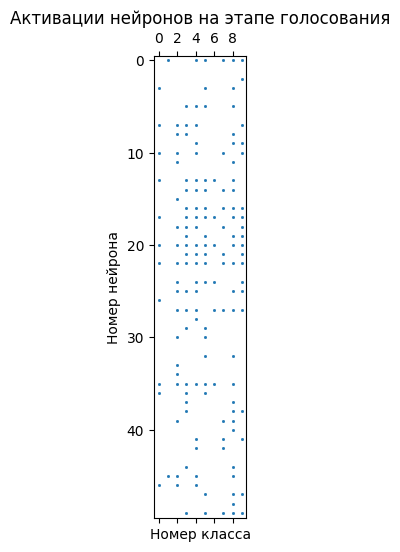

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Размер графика, можно изменить
plt.spy(matrix, markersize=1)  # markersize отвечает за размер точек

plt.xlabel('Номер класса')
plt.ylabel('Номер нейрона')
plt.title('Активации нейронов на этапе голосования')
plt.show()


In [42]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

num_neuron = 2000
num_synapses = DATA_FLATTEN_SHAPE
eta = 0.3 * torch.ones(num_neuron)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleLayerNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
layer = Layer(num_neuron, num_synapses, eta, base = 200.0, device = device, lr_decay = "None")
norms = []
preds = []
num_epochs = 1
num_epochs_classifier_head = 0
cnt = 0 
eps = 0.01
metrics = []
losses = []
for _ in tqdm(range(num_epochs), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device)  # Перемещаем изображение на устройство
        img = img.reshape(-1)  # Преобразуем в одномерный тензор
        y = layer.train(img)
    
        if(i % 10000 == 0):
            norms.append(torch.linalg.norm(layer.get_weights(), axis = 0).mean())
            print(torch.linalg.norm(layer.get_weights(), axis = 0).mean())


for _ in tqdm(range(num_epochs_classifier_head), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device) 
        label = label.to(device)
        img = img.reshape(-1)  
        y = layer.get_activations(img)
        y = y/torch.linalg.norm(y)
        optimizer.zero_grad()
        output = model(y)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img = torch.squeeze(img).to(device) 
            label = label.to(device)
            img = img.reshape(-1) 
            y = layer.get_activations(img)
            y = y/torch.linalg.norm(y)
            output = model(y)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim = 1, keepdims = True)
            correct += pred.eq(label.view_as(pred)).sum().item()

   
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    metrics.append(accuracy)
    losses.append(test_loss)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
for img, label in train_loader:
    img = torch.squeeze(img).to(device)
    img = img.reshape(-1)
    layer.voting_of_neurons(img,label)


list_of_dicts = layer.get_vote() # выводит результаты голосования нейронов 

Номер эпохи:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(8.4004, device='cuda:0')
tensor(6.1138, device='cuda:0')
tensor(5.2609, device='cuda:0')
tensor(4.7353, device='cuda:0')
tensor(4.3559, device='cuda:0')
tensor(4.0947, device='cuda:0')


Номер эпохи: 100%|██████████| 1/1 [00:43<00:00, 43.80s/it]
Номер эпохи: 0it [00:00, ?it/s]


# Активации нейронов во время голосования нейронов с фиксированным шагом обучения

In [43]:
import numpy as np
import matplotlib.pyplot as plt
amount_of_neurons = 50
list_of_dicts = list_of_dicts[0:amount_of_neurons]
matrix = np.zeros((amount_of_neurons, 10), dtype=int)
for i, row_dict in enumerate(list_of_dicts):
    for col, value in row_dict.items():
        matrix[i, col] = value
        



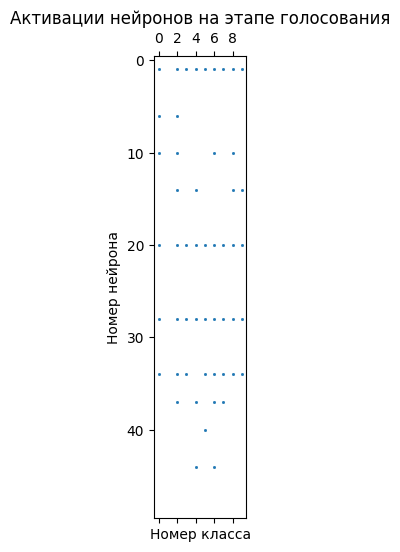

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Размер графика, можно изменить
plt.spy(matrix, markersize=1)  # markersize отвечает за размер точек

plt.xlabel('Номер класса')
plt.ylabel('Номер нейрона')
plt.title('Активации нейронов на этапе голосования')
plt.show()


In [36]:
y = layer.y_get
b = layer.b_get


y = np.array([[t.item() for t in row] for row in y])  # shape (2000, 1000)
b = np.array([[t.item() for t in row] for row in b])  # shape (2000, 1000)
y = y.reshape(num_neuron,SUBSET_SIZE)
b = b.reshape(num_neuron, SUBSET_SIZE)

## Графики активаций нейронов ($y_k$) в процессе обучения

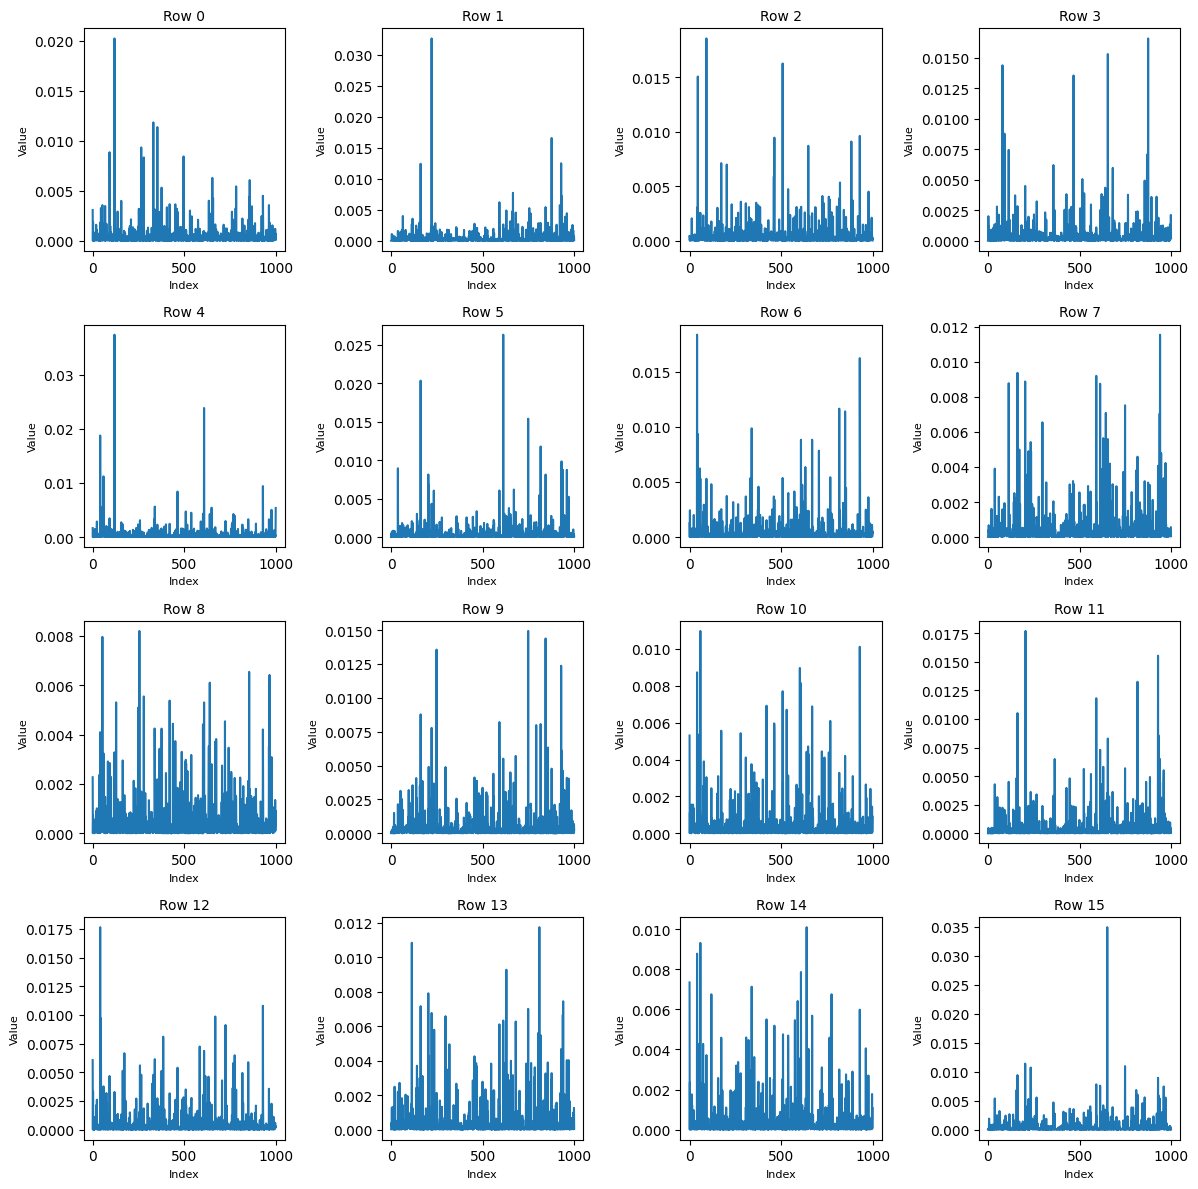

In [37]:
import matplotlib.pyplot as plt
import numpy as np  

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    row_data = y[i, :]  
    ax.plot(row_data)   
    ax.set_title(f'Row {i}', fontsize=10)
    ax.set_xlabel('Index', fontsize=8)
    ax.set_ylabel('Value', fontsize=8)

plt.tight_layout()
plt.show()

## Визуализация весов нейронов после обучения (веса напоминают некоторые классы при этом учитывая еще и стиль написания и другие скрытые причины)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig, axes = plt.subplots(4, 4, figsize=(10, 10))
weights = layer.get_weights().cpu()
vmin, vmax = weights.min(), weights.max()

for i, ax in enumerate(axes.flat):
    if i < weights.shape[1]:  
        img = weights[:, i].reshape(28, 28)
        
        im = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f'Нейрон {i}')
        ax.axis('off')  
    else:
        ax.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, color='blue', linewidth=4)       
plt.xlabel('Эпоха')     
plt.ylabel('Значение функции потерь')      
plt.title('График функции потерь классификатора')
plt.grid(True)         
plt.show() 

In [ ]:
plt.plot(metrics, color = 'green', linewidth=4)        # Рисует график по значениям из списка losses
plt.xlabel('Эпоха')     # Подпись оси X (обычно номер эпохи)
plt.ylabel('Точность')      # Подпись оси Y (значение функции потерь)
plt.title('График точности')
plt.grid(True)          # Включает сетку для удобства чтения графика
plt.show() 

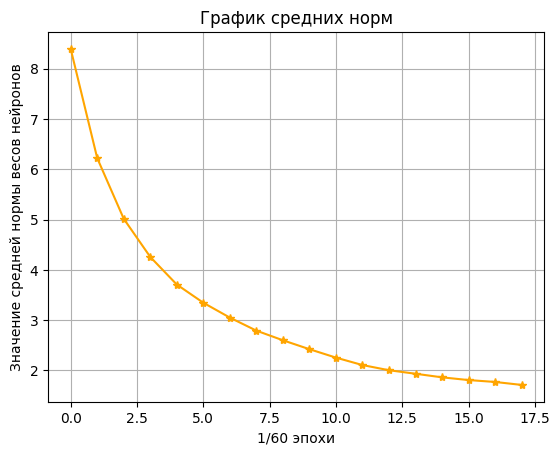

In [61]:

norm1 = [norm.cpu().detach().numpy() for norm in norms]
plt.plot(norm1, color = 'orange', marker = "*")       
plt.xlabel('1/60 эпохи')     
plt.ylabel('Значение средней нормы весов нейронов')    
plt.title('График средних норм')
plt.grid(True)         
plt.show() 

## Полученные метрики на тестовых данных

In [ ]:
import numpy as np
import torch
import gc


pred_labels = []
true_labels = []

for img, label in test_loader:
    img = torch.squeeze(img).to(device)
    img = img.reshape(-1)
    true_labels.append(label)
    pred_labels.append(layer.get_predict(img))



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



accuracy = accuracy_score(true_labels, pred_labels)

precision = precision_score(true_labels, pred_labels, average='weighted')

recall = recall_score(true_labels, pred_labels, average='weighted')

f1 = f1_score(true_labels, pred_labels, average='weighted')

conf_matrix = confusion_matrix(true_labels, pred_labels)


accuracy = accuracy_score(true_labels, pred_labels)

f1 = f1_score(true_labels, pred_labels, average='weighted')

conf_matrix = confusion_matrix(true_labels, pred_labels)

classification_rep = classification_report(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Предположим, что weights - ваша матрица весов размером (784, 2000)
# weights = np.load('my_weights.npy')  # Закомментируйте, если переменная уже определена

# Создаем сетку для визуализации, например 4×4 нейрона
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
weights = layer.get_weights().cpu()
# Найдем глобальные min и max для одинакового масштаба всех изображений
vmin, vmax = weights.min(), weights.max()

# Визуализируем первые 16 нейронов (можно изменить индексы для просмотра других)
for i, ax in enumerate(axes.flat):
    if i < weights.shape[1]:  # Проверка, что индекс не выходит за границы
        # Преобразуем веса i-го нейрона в изображение 28×28
        img = weights[:, i].reshape(28, 28)
        
        # Визуализируем изображение
        im = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f'Нейрон {i}')
        ax.axis('off')  # Отключаем оси
    else:
        ax.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()


# Приавло Ойи и затем классификация/кластеризация c помощью SoftHebb и head_classifier. Используем Oja's rule(W_oja) как PCA перед обучением на основном пайплайне. 

In [2]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

n_components = 400
num_epochs_oj = 30
MNIST_SHAPE = 784
eta_oja = 0.01
device = "cuda"
W_oja = 0.01*torch.randn((MNIST_SHAPE, n_components), device = device)
for _ in tqdm(range(num_epochs_oj), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device)  # Перемещаем изображение на устройство
        img = img.reshape(-1,1)  # Преобразуем в одномерный тензор
        x = img/torch.linalg.norm(img)
        y = W_oja.T @ x
        delta_W = eta_oja * (x @ y.T - W_oja @ (y @ y.T))
        W_oja += delta_W
    # Нормировка весов
    W_oja = W_oja / torch.linalg.norm(W_oja, axis=0)   




Номер эпохи: 100%|██████████| 30/30 [16:22<00:00, 32.73s/it]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

class SingleLayerNet(nn.Module):
    def __init__(self, num_digits):
        super().__init__()
        self.num_digits = num_digits
        self.fc = nn.Linear(self.num_digits, 10)  

    def forward(self, x):
        x = x.view(-1, self.num_digits)  
        return self.fc(x)

class Layer:
    def __init__(self, num_neuron, num_synapses, eta, base, device, lr_decay="exp", w_ch1=[], w_ch2=[], bias=[]):
        self.num_neuron = num_neuron
        self.num_synapses = num_synapses
        self.neurons = []
        self.eta = eta.reshape(-1,1).to(device)
        self.w_ch1 = w_ch1
        self.w_ch2 = w_ch2
        self.bias = bias
        self.device = device
        self.lr_decay = lr_decay
        self.eta_0 = self.eta
        self.W = (0.3*torch.randn((num_synapses, num_neuron))).to(device)
        self.y_get = []
        self.b_get = []
      
        self.b = torch.zeros((num_neuron,1), device = self.device)
        self.dicts = [{} for i in range(self.num_neuron)]
        self.base = base


    def get_weights(self):
        return self.W

    def get_bias(self):
        return self.b

    def get_vote(self):
        return self.dicts

    def voting_of_neurons(self, x, label):

        u = torch.zeros((self.num_neuron, 1), device=self.device)  
        y = torch.zeros((self.num_neuron, 1), device=self.device) 
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        label = label.item()
        max_activ = torch.argmax(y) 
        self.dicts[max_activ][label] = self.dicts[max_activ].get(label, 0) + 1

    def get_predict(self, x):

        u = torch.zeros((self.num_neuron, 1), device=self.device) 
        y = torch.zeros((self.num_neuron, 1), device=self.device) 
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        a = torch.argmax(y)
        if (self.dicts[a]):
            label = max(self.dicts[a], key=self.dicts[a].get) 
        else:
            label = -1
        return label

    def train(self, x):
        
        u = torch.zeros((self.num_neuron, 1), device=self.device)  
        y = torch.zeros((self.num_neuron, 1), device=self.device) 
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))

        u = self.W.T @ x
       

        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
        # для графиков ///////////////////////////////////////
        self.y_get.append(y)
      
        term1 = self.eta.T * (x @ y.T) 
        term2 = self.eta.T * self.W * (u.T * y.T)  
        delta_W = term1-term2
        self.W = self.W + delta_W
       
        # для графиков ///////////////////////////
        self.b_get.append(self.b)
       
    def get_activations(self, x):
        u = torch.zeros((self.num_neuron, 1), device=self.device) 
        y = torch.zeros((self.num_neuron, 1), device=self.device) 
        x = x / torch.linalg.norm(x)
        x = torch.reshape(x, (-1, 1))
        y = torch.reshape(y, (-1, 1))
        u = torch.reshape(u, (-1, 1))

        
        u = self.W.T @ x
        y = self.base ** (u + self.b) / torch.sum(self.base ** (u + self.b))
       
        
        return y
    def w_plt1(self):
        return self.w_ch1

    def w_plt2(self):
        return self.w_ch2

    def y_get(self):
        return self.y_get
        
    def b_get(self):
        return self.b_get

    def w_plt2(self):
        return self.w_ch2  
        
    def lr_update(self):
        norm = torch.linalg.norm(self.W, axis = 0, keepdims = True).reshape(-1,1)
        nc = 1e-10
        self.eta = (self.eta_0 * (pow(torch.abs(norm - torch.ones_like(norm)), 2))+nc).reshape(-1,1)
    def update_lr(self, t):
        if(self.lr_decay == "exp"):
            gamma_exp = 0.4
            self.eta = self.eta_0*np.exp(-gamma_exp*t)
            self.eta = torch.clip(self.eta, a_min = 0.0055, a_max = 1)
        elif(self.lr_decay == "linear"):
            gamma_lin = 0.95
            self.eta = self.eta_0*(gamma_lin)**t
            self.eta = torch.clip(self.eta, a_min = 0.0055, a_max = 1)
        elif(self.lr_decay == "None"):
            self.eta = self.eta


In [4]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

num_neuron = 2000
num_synapses = W_oja.shape[1]
eta = 0.4 * torch.ones(num_neuron)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleLayerNet(num_digits = num_neuron)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
layer = Layer(num_neuron, num_synapses, eta, base = 200.0, device = device, lr_decay = "None")
norms = []
preds = []
num_epochs = 2
num_epochs_classifier_head = 100
cnt = 0 
eps = 0.01
metrics = []
losses = []

for _ in tqdm(range(num_epochs), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device)  
        img = img.reshape(-1)  
        img = W_oja.T @ img
        y = layer.train(img)
        layer.lr_update()
        if(i % 10000 == 0):
            norms.append(torch.linalg.norm(layer.get_weights(), axis = 0).mean())
            print(torch.linalg.norm(layer.get_weights(), axis = 0).mean())


for _ in tqdm(range(num_epochs_classifier_head), desc = "Номер эпохи"):
    for i, (img, label) in enumerate(train_loader):
        img = torch.squeeze(img).to(device) 
        label = label.to(device)
        img = img.reshape(-1)  
        img = W_oja.T @ img        
        y = layer.get_activations(img)
        y = y/torch.linalg.norm(y)
        optimizer.zero_grad()
        output = model(y)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img = torch.squeeze(img).to(device) 
            label = label.to(device)
            img = img.reshape(-1) 
            img = W_oja.T @ img
            y = layer.get_activations(img)
            y = y/torch.linalg.norm(y)
            output = model(y)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim = 1, keepdims = True)
            correct += pred.eq(label.view_as(pred)).sum().item()

   
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    metrics.append(accuracy)
    losses.append(test_loss)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
for img, label in train_loader:
    img = torch.squeeze(img).to(device)
    img = img.reshape(-1)
    img = W_oja.T @ img
    layer.voting_of_neurons(img,label)

list_of_dicts = layer.get_vote()

Номер эпохи:   0%|          | 0/2 [00:00<?, ?it/s]

tensor(5.9947, device='cuda:0')
tensor(1.9746, device='cuda:0')
tensor(1.5690, device='cuda:0')
tensor(1.3861, device='cuda:0')
tensor(1.2949, device='cuda:0')
tensor(1.2322, device='cuda:0')


Номер эпохи:  50%|█████     | 1/2 [00:54<00:54, 54.20s/it]

tensor(1.1922, device='cuda:0')
tensor(1.1725, device='cuda:0')
tensor(1.1612, device='cuda:0')
tensor(1.1464, device='cuda:0')
tensor(1.1386, device='cuda:0')
tensor(1.1322, device='cuda:0')


Номер эпохи:   1%|          | 1/100 [01:44<2:52:46, 104.71s/it]


Test set: Average loss: 1.2271, Accuracy: 7762/10000 (77.62%)



Номер эпохи:   2%|▏         | 2/100 [03:28<2:50:35, 104.44s/it]


Test set: Average loss: 0.9050, Accuracy: 7934/10000 (79.34%)



Номер эпохи:   3%|▎         | 3/100 [05:12<2:48:32, 104.25s/it]


Test set: Average loss: 0.7284, Accuracy: 8332/10000 (83.32%)



Номер эпохи:   4%|▍         | 4/100 [06:59<2:47:56, 104.97s/it]


Test set: Average loss: 0.6349, Accuracy: 8470/10000 (84.70%)



Номер эпохи:   5%|▌         | 5/100 [08:45<2:47:14, 105.62s/it]


Test set: Average loss: 0.5790, Accuracy: 8581/10000 (85.81%)



Номер эпохи:   6%|▌         | 6/100 [10:30<2:45:10, 105.43s/it]


Test set: Average loss: 0.5436, Accuracy: 8646/10000 (86.46%)



Номер эпохи:   7%|▋         | 7/100 [12:15<2:42:56, 105.12s/it]


Test set: Average loss: 0.5290, Accuracy: 8540/10000 (85.40%)



Номер эпохи:   8%|▊         | 8/100 [14:00<2:41:10, 105.12s/it]


Test set: Average loss: 0.4912, Accuracy: 8705/10000 (87.05%)



Номер эпохи:   9%|▉         | 9/100 [15:46<2:40:04, 105.54s/it]


Test set: Average loss: 0.4728, Accuracy: 8755/10000 (87.55%)



Номер эпохи:  10%|█         | 10/100 [17:32<2:38:30, 105.68s/it]


Test set: Average loss: 0.4676, Accuracy: 8778/10000 (87.78%)



Номер эпохи:  11%|█         | 11/100 [19:17<2:36:24, 105.45s/it]


Test set: Average loss: 0.4642, Accuracy: 8722/10000 (87.22%)



Номер эпохи:  12%|█▏        | 12/100 [21:04<2:35:13, 105.84s/it]


Test set: Average loss: 0.4385, Accuracy: 8828/10000 (88.28%)



Номер эпохи:  13%|█▎        | 13/100 [22:51<2:33:52, 106.12s/it]


Test set: Average loss: 0.4217, Accuracy: 8870/10000 (88.70%)



Номер эпохи:  14%|█▍        | 14/100 [24:35<2:31:17, 105.55s/it]


Test set: Average loss: 0.4502, Accuracy: 8758/10000 (87.58%)



Номер эпохи:  15%|█▌        | 15/100 [26:19<2:28:45, 105.00s/it]


Test set: Average loss: 0.4269, Accuracy: 8805/10000 (88.05%)



Номер эпохи:  16%|█▌        | 16/100 [28:03<2:26:47, 104.85s/it]


Test set: Average loss: 0.4174, Accuracy: 8800/10000 (88.00%)



Номер эпохи:  17%|█▋        | 17/100 [29:48<2:24:49, 104.69s/it]


Test set: Average loss: 0.4005, Accuracy: 8869/10000 (88.69%)



Номер эпохи:  18%|█▊        | 18/100 [31:32<2:23:03, 104.68s/it]


Test set: Average loss: 0.3996, Accuracy: 8884/10000 (88.84%)



Номер эпохи:  19%|█▉        | 19/100 [33:17<2:21:07, 104.54s/it]


Test set: Average loss: 0.3954, Accuracy: 8895/10000 (88.95%)



Номер эпохи:  20%|██        | 20/100 [35:01<2:19:32, 104.66s/it]


Test set: Average loss: 0.3833, Accuracy: 8944/10000 (89.44%)



Номер эпохи:  21%|██        | 21/100 [36:47<2:18:19, 105.05s/it]


Test set: Average loss: 0.3878, Accuracy: 8896/10000 (88.96%)



Номер эпохи:  22%|██▏       | 22/100 [38:34<2:17:10, 105.52s/it]


Test set: Average loss: 0.3825, Accuracy: 8903/10000 (89.03%)



Номер эпохи:  23%|██▎       | 23/100 [40:20<2:15:31, 105.60s/it]


Test set: Average loss: 0.3796, Accuracy: 8950/10000 (89.50%)



Номер эпохи:  24%|██▍       | 24/100 [42:05<2:13:32, 105.43s/it]


Test set: Average loss: 0.3738, Accuracy: 8955/10000 (89.55%)



Номер эпохи:  25%|██▌       | 25/100 [43:50<2:11:31, 105.21s/it]


Test set: Average loss: 0.3970, Accuracy: 8857/10000 (88.57%)



Номер эпохи:  26%|██▌       | 26/100 [45:34<2:09:22, 104.90s/it]


Test set: Average loss: 0.3682, Accuracy: 8946/10000 (89.46%)



Номер эпохи:  27%|██▋       | 27/100 [47:18<2:07:33, 104.84s/it]


Test set: Average loss: 0.3652, Accuracy: 8953/10000 (89.53%)



Номер эпохи:  28%|██▊       | 28/100 [49:04<2:06:01, 105.02s/it]


Test set: Average loss: 0.3737, Accuracy: 8946/10000 (89.46%)



Номер эпохи:  29%|██▉       | 29/100 [50:49<2:04:12, 104.97s/it]


Test set: Average loss: 0.3649, Accuracy: 8962/10000 (89.62%)



Номер эпохи:  30%|███       | 30/100 [52:34<2:02:40, 105.15s/it]


Test set: Average loss: 0.3562, Accuracy: 9005/10000 (90.05%)



Номер эпохи:  31%|███       | 31/100 [54:19<2:00:51, 105.10s/it]


Test set: Average loss: 0.3649, Accuracy: 8952/10000 (89.52%)



Номер эпохи:  32%|███▏      | 32/100 [56:04<1:58:54, 104.92s/it]


Test set: Average loss: 0.3527, Accuracy: 9001/10000 (90.01%)



Номер эпохи:  33%|███▎      | 33/100 [57:48<1:56:52, 104.67s/it]


Test set: Average loss: 0.3584, Accuracy: 8967/10000 (89.67%)



Номер эпохи:  34%|███▍      | 34/100 [59:31<1:54:46, 104.34s/it]


Test set: Average loss: 0.3508, Accuracy: 9008/10000 (90.08%)



Номер эпохи:  35%|███▌      | 35/100 [1:01:15<1:52:54, 104.23s/it]


Test set: Average loss: 0.3668, Accuracy: 8959/10000 (89.59%)



Номер эпохи:  36%|███▌      | 36/100 [1:02:59<1:50:51, 103.93s/it]


Test set: Average loss: 0.3636, Accuracy: 8969/10000 (89.69%)



Номер эпохи:  37%|███▋      | 37/100 [1:04:42<1:49:01, 103.83s/it]


Test set: Average loss: 0.3388, Accuracy: 9025/10000 (90.25%)



Номер эпохи:  38%|███▊      | 38/100 [1:06:26<1:47:22, 103.90s/it]


Test set: Average loss: 0.3424, Accuracy: 9039/10000 (90.39%)



Номер эпохи:  39%|███▉      | 39/100 [1:08:10<1:45:29, 103.76s/it]


Test set: Average loss: 0.3462, Accuracy: 9006/10000 (90.06%)



Номер эпохи:  40%|████      | 40/100 [1:09:53<1:43:43, 103.73s/it]


Test set: Average loss: 0.3491, Accuracy: 9007/10000 (90.07%)



Номер эпохи:  41%|████      | 41/100 [1:11:37<1:41:59, 103.71s/it]


Test set: Average loss: 0.3432, Accuracy: 9028/10000 (90.28%)



Номер эпохи:  42%|████▏     | 42/100 [1:13:21<1:40:14, 103.70s/it]


Test set: Average loss: 0.3353, Accuracy: 9046/10000 (90.46%)



Номер эпохи:  43%|████▎     | 43/100 [1:15:05<1:38:37, 103.81s/it]


Test set: Average loss: 0.3487, Accuracy: 8978/10000 (89.78%)



Номер эпохи:  44%|████▍     | 44/100 [1:16:48<1:36:46, 103.68s/it]


Test set: Average loss: 0.3437, Accuracy: 9033/10000 (90.33%)



Номер эпохи:  45%|████▌     | 45/100 [1:18:32<1:35:04, 103.72s/it]


Test set: Average loss: 0.3408, Accuracy: 9040/10000 (90.40%)



Номер эпохи:  46%|████▌     | 46/100 [1:20:16<1:33:24, 103.78s/it]


Test set: Average loss: 0.3353, Accuracy: 9016/10000 (90.16%)



Номер эпохи:  47%|████▋     | 47/100 [1:21:59<1:31:35, 103.69s/it]


Test set: Average loss: 0.3360, Accuracy: 9039/10000 (90.39%)



Номер эпохи:  48%|████▊     | 48/100 [1:23:42<1:29:40, 103.48s/it]


Test set: Average loss: 0.3398, Accuracy: 8999/10000 (89.99%)



Номер эпохи:  49%|████▉     | 49/100 [1:25:26<1:28:06, 103.65s/it]


Test set: Average loss: 0.3307, Accuracy: 9078/10000 (90.78%)



Номер эпохи:  50%|█████     | 50/100 [1:27:10<1:26:20, 103.61s/it]


Test set: Average loss: 0.3247, Accuracy: 9070/10000 (90.70%)



Номер эпохи:  51%|█████     | 51/100 [1:28:53<1:24:29, 103.47s/it]


Test set: Average loss: 0.3385, Accuracy: 9038/10000 (90.38%)



Номер эпохи:  52%|█████▏    | 52/100 [1:30:36<1:22:45, 103.44s/it]


Test set: Average loss: 0.3288, Accuracy: 9079/10000 (90.79%)



Номер эпохи:  53%|█████▎    | 53/100 [1:32:20<1:21:06, 103.54s/it]


Test set: Average loss: 0.3284, Accuracy: 9060/10000 (90.60%)



Номер эпохи:  54%|█████▍    | 54/100 [1:34:04<1:19:26, 103.63s/it]


Test set: Average loss: 0.3435, Accuracy: 9042/10000 (90.42%)



Номер эпохи:  55%|█████▌    | 55/100 [1:35:47<1:17:35, 103.45s/it]


Test set: Average loss: 0.3280, Accuracy: 9051/10000 (90.51%)



Номер эпохи:  56%|█████▌    | 56/100 [1:37:30<1:15:49, 103.39s/it]


Test set: Average loss: 0.3234, Accuracy: 9083/10000 (90.83%)



Номер эпохи:  57%|█████▋    | 57/100 [1:39:13<1:13:57, 103.21s/it]


Test set: Average loss: 0.3253, Accuracy: 9074/10000 (90.74%)



Номер эпохи:  58%|█████▊    | 58/100 [1:40:56<1:12:09, 103.07s/it]


Test set: Average loss: 0.3303, Accuracy: 9010/10000 (90.10%)



Номер эпохи:  59%|█████▉    | 59/100 [1:42:39<1:10:31, 103.20s/it]


Test set: Average loss: 0.3355, Accuracy: 9023/10000 (90.23%)



Номер эпохи:  60%|██████    | 60/100 [1:44:25<1:09:11, 103.79s/it]


Test set: Average loss: 0.3172, Accuracy: 9079/10000 (90.79%)



Номер эпохи:  61%|██████    | 61/100 [1:46:07<1:07:14, 103.44s/it]


Test set: Average loss: 0.3191, Accuracy: 9071/10000 (90.71%)



Номер эпохи:  62%|██████▏   | 62/100 [1:47:49<1:05:11, 102.94s/it]


Test set: Average loss: 0.3255, Accuracy: 9085/10000 (90.85%)



Номер эпохи:  63%|██████▎   | 63/100 [1:49:31<1:03:19, 102.70s/it]


Test set: Average loss: 0.3160, Accuracy: 9109/10000 (91.09%)



Номер эпохи:  64%|██████▍   | 64/100 [1:51:14<1:01:40, 102.78s/it]


Test set: Average loss: 0.3233, Accuracy: 9072/10000 (90.72%)



Номер эпохи:  65%|██████▌   | 65/100 [1:52:56<59:51, 102.60s/it]  


Test set: Average loss: 0.3219, Accuracy: 9047/10000 (90.47%)



Номер эпохи:  66%|██████▌   | 66/100 [1:54:39<58:09, 102.65s/it]


Test set: Average loss: 0.3389, Accuracy: 9052/10000 (90.52%)



Номер эпохи:  67%|██████▋   | 67/100 [1:56:22<56:33, 102.82s/it]


Test set: Average loss: 0.3203, Accuracy: 9039/10000 (90.39%)



Номер эпохи:  68%|██████▊   | 68/100 [1:58:05<54:45, 102.67s/it]


Test set: Average loss: 0.3183, Accuracy: 9099/10000 (90.99%)



Номер эпохи:  69%|██████▉   | 69/100 [1:59:47<52:59, 102.57s/it]


Test set: Average loss: 0.3211, Accuracy: 9082/10000 (90.82%)



Номер эпохи:  70%|███████   | 70/100 [2:01:30<51:20, 102.68s/it]


Test set: Average loss: 0.3188, Accuracy: 9082/10000 (90.82%)



Номер эпохи:  71%|███████   | 71/100 [2:03:12<49:33, 102.52s/it]


Test set: Average loss: 0.3239, Accuracy: 9080/10000 (90.80%)



Номер эпохи:  72%|███████▏  | 72/100 [2:04:54<47:47, 102.40s/it]


Test set: Average loss: 0.3222, Accuracy: 9090/10000 (90.90%)



Номер эпохи:  73%|███████▎  | 73/100 [2:06:37<46:08, 102.53s/it]


Test set: Average loss: 0.3261, Accuracy: 9025/10000 (90.25%)



Номер эпохи:  74%|███████▍  | 74/100 [2:08:19<44:23, 102.45s/it]


Test set: Average loss: 0.3246, Accuracy: 9068/10000 (90.68%)



Номер эпохи:  75%|███████▌  | 75/100 [2:10:01<42:40, 102.41s/it]


Test set: Average loss: 0.3130, Accuracy: 9109/10000 (91.09%)



Номер эпохи:  76%|███████▌  | 76/100 [2:11:45<41:03, 102.65s/it]


Test set: Average loss: 0.3188, Accuracy: 9080/10000 (90.80%)



Номер эпохи:  77%|███████▋  | 77/100 [2:13:28<39:23, 102.76s/it]


Test set: Average loss: 0.3099, Accuracy: 9105/10000 (91.05%)



Номер эпохи:  78%|███████▊  | 78/100 [2:15:10<37:40, 102.76s/it]


Test set: Average loss: 0.3132, Accuracy: 9091/10000 (90.91%)



Номер эпохи:  79%|███████▉  | 79/100 [2:16:54<36:00, 102.90s/it]


Test set: Average loss: 0.3202, Accuracy: 9094/10000 (90.94%)



Номер эпохи:  80%|████████  | 80/100 [2:18:36<34:17, 102.87s/it]


Test set: Average loss: 0.3245, Accuracy: 9084/10000 (90.84%)



Номер эпохи:  81%|████████  | 81/100 [2:20:19<32:33, 102.79s/it]


Test set: Average loss: 0.3141, Accuracy: 9102/10000 (91.02%)



Номер эпохи:  82%|████████▏ | 82/100 [2:22:02<30:48, 102.68s/it]


Test set: Average loss: 0.3128, Accuracy: 9118/10000 (91.18%)



Номер эпохи:  83%|████████▎ | 83/100 [2:23:44<29:05, 102.68s/it]


Test set: Average loss: 0.3142, Accuracy: 9102/10000 (91.02%)



Номер эпохи:  84%|████████▍ | 84/100 [2:25:27<27:24, 102.79s/it]


Test set: Average loss: 0.3073, Accuracy: 9126/10000 (91.26%)



Номер эпохи:  85%|████████▌ | 85/100 [2:27:10<25:42, 102.86s/it]


Test set: Average loss: 0.3127, Accuracy: 9073/10000 (90.73%)



Номер эпохи:  86%|████████▌ | 86/100 [2:28:53<23:58, 102.73s/it]


Test set: Average loss: 0.3071, Accuracy: 9106/10000 (91.06%)



Номер эпохи:  87%|████████▋ | 87/100 [2:30:35<22:12, 102.51s/it]


Test set: Average loss: 0.3102, Accuracy: 9144/10000 (91.44%)



Номер эпохи:  88%|████████▊ | 88/100 [2:32:18<20:32, 102.74s/it]


Test set: Average loss: 0.3161, Accuracy: 9092/10000 (90.92%)



Номер эпохи:  89%|████████▉ | 89/100 [2:34:01<18:51, 102.85s/it]


Test set: Average loss: 0.3098, Accuracy: 9145/10000 (91.45%)



Номер эпохи:  90%|█████████ | 90/100 [2:35:44<17:07, 102.73s/it]


Test set: Average loss: 0.3159, Accuracy: 9094/10000 (90.94%)



Номер эпохи:  91%|█████████ | 91/100 [2:37:27<15:26, 102.93s/it]


Test set: Average loss: 0.3094, Accuracy: 9147/10000 (91.47%)



Номер эпохи:  92%|█████████▏| 92/100 [2:39:10<13:43, 102.97s/it]


Test set: Average loss: 0.3263, Accuracy: 9033/10000 (90.33%)



Номер эпохи:  93%|█████████▎| 93/100 [2:40:53<12:00, 102.93s/it]


Test set: Average loss: 0.3089, Accuracy: 9132/10000 (91.32%)



Номер эпохи:  94%|█████████▍| 94/100 [2:42:36<10:18, 103.05s/it]


Test set: Average loss: 0.3170, Accuracy: 9084/10000 (90.84%)



Номер эпохи:  95%|█████████▌| 95/100 [2:44:19<08:35, 103.04s/it]


Test set: Average loss: 0.3084, Accuracy: 9114/10000 (91.14%)



Номер эпохи:  96%|█████████▌| 96/100 [2:46:02<06:52, 103.04s/it]


Test set: Average loss: 0.3132, Accuracy: 9104/10000 (91.04%)



Номер эпохи:  97%|█████████▋| 97/100 [2:47:45<05:09, 103.07s/it]


Test set: Average loss: 0.3141, Accuracy: 9123/10000 (91.23%)



Номер эпохи:  98%|█████████▊| 98/100 [2:49:30<03:27, 103.64s/it]


Test set: Average loss: 0.3068, Accuracy: 9116/10000 (91.16%)



Номер эпохи:  99%|█████████▉| 99/100 [2:51:14<01:43, 103.67s/it]


Test set: Average loss: 0.3043, Accuracy: 9157/10000 (91.57%)



Номер эпохи: 100%|██████████| 100/100 [2:52:58<00:00, 103.79s/it]


Test set: Average loss: 0.3036, Accuracy: 9126/10000 (91.26%)



# На ранних эпохах такой подход лучше предыдущего, нежели без Oja's rule. Но итоговое качество получилось на пару процентов ниже в силу потери некоторой информации из за Oja's rule. Но сэкономили на вычислениях.

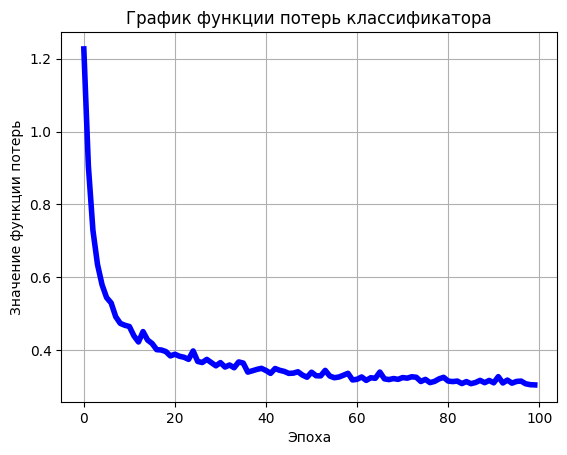

In [6]:
import matplotlib.pyplot as plt

plt.plot(losses, color='blue', linewidth=4)        
plt.xlabel('Эпоха')    
plt.ylabel('Значение функции потерь')      
plt.title('График функции потерь классификатора')
plt.grid(True)          
plt.show() 

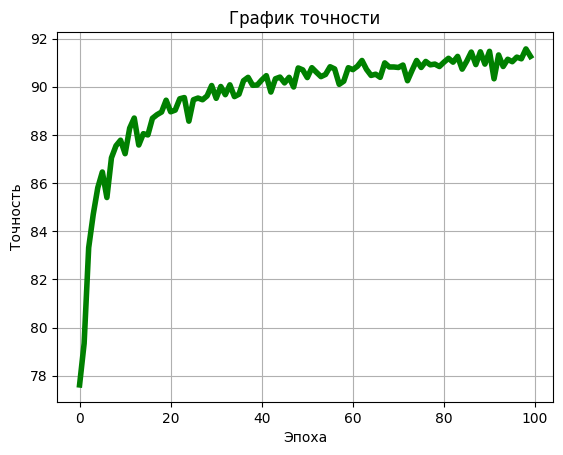

In [7]:
plt.plot(metrics, color = 'green', linewidth=4)        
plt.xlabel('Эпоха')   
plt.ylabel('Точность')      
plt.title('График точности')
plt.grid(True)          
plt.show() 

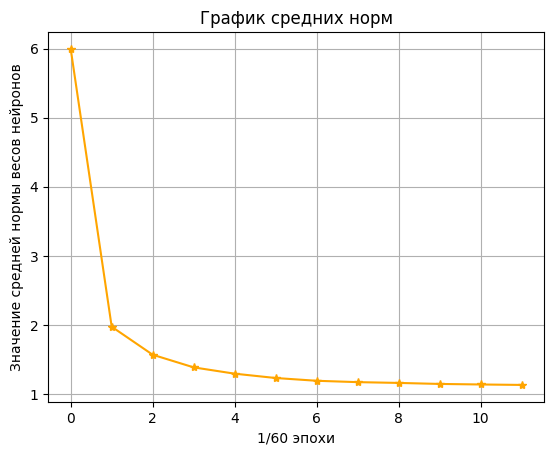

In [8]:

norm1 = [norm.cpu().detach().numpy() for norm in norms]
plt.plot(norm1, color = 'orange', marker = "*")        
plt.xlabel('1/60 эпохи')    
plt.ylabel('Значение средней нормы весов нейронов')     
plt.title('График средних норм')
plt.grid(True)         
plt.show() 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
weights = layer.get_weights().cpu()
vmin, vmax = weights.min(), weights.max()

for i, ax in enumerate(axes.flat):
    if i < weights.shape[1]: 
        img = weights[:, i].reshape(20, 20)
        
        im = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f'Нейрон {i}')
        ax.axis('off')  
    else:of
        ax.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()


# Точность SoftHebb отдельно за 1 эпоху

In [5]:
import numpy as np
import torch
import gc


pred_labels = []
true_labels = []

for img, label in test_loader:
    img = torch.squeeze(img).to(device)
    img = img.reshape(-1)
    img = W_oja.T @ img
    true_labels.append(label)
    pred_labels.append(layer.get_predict(img))



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



accuracy = accuracy_score(true_labels, pred_labels)

precision = precision_score(true_labels, pred_labels, average='weighted')

recall = recall_score(true_labels, pred_labels, average='weighted')

f1 = f1_score(true_labels, pred_labels, average='weighted')

conf_matrix = confusion_matrix(true_labels, pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)

f1 = f1_score(true_labels, pred_labels, average='weighted')

# Матрица ошибок
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Полный отчёт по всем классам
classification_rep = classification_report(true_labels, pred_labels)

# Вывод результатов
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6427
Precision: 0.6385
Recall: 0.6427
F1-score: 0.6373

Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0    0    0]
 [   0  822    0   15   25    4   55   34    8    6   11]
 [   0    0 1053   16   14    6    7    5    3   24    7]
 [   4   30   54  633   68   41   21   79   20   71   11]
 [   3   62   27   68  594   12   97   44   26   62   15]
 [   6   17   22   31   19  523   25   94  109   19  117]
 [   2   92   26   12   97   25  459   48   32   61   38]
 [   5   64   18   48    4   71   37  670   12   16   13]
 [   3   23   55   39    9   37   25   19  731   15   72]
 [   4   17   40   65  129   24   77   95   29  446   48]
 [   1   15   25   25   28  123   37   42  178   39  496]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.72      0.84      0.77       980
           1       0.80      0.93      0.86      1135
           2       0.66      0.61 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(list_of_dicts)

[{8: 1, 3: 1}, {1: 127, 2: 12, 3: 2, 8: 3}, {4: 1}, {2: 1, 7: 1}, {8: 6, 7: 5, 9: 2, 2: 1}, {4: 2}, {5: 6, 6: 11, 2: 1, 3: 1, 4: 2}, {4: 16, 9: 41, 8: 7, 7: 1, 2: 5, 5: 1}, {5: 5, 6: 7, 8: 4}, {5: 3, 3: 3, 6: 1}, {4: 2, 8: 2, 6: 7, 5: 1}, {1: 13, 8: 6, 2: 2, 4: 1}, {0: 2}, {5: 9, 8: 28, 7: 6, 2: 12, 3: 5, 6: 1}, {5: 3, 6: 13, 7: 1, 9: 3, 0: 1, 8: 2, 2: 2, 4: 1}, {7: 3, 3: 3, 5: 10}, {3: 26, 7: 21, 8: 4, 9: 8, 4: 4, 5: 3, 6: 1}, {3: 2, 6: 2, 0: 7}, {8: 64, 5: 66, 3: 84, 0: 1, 2: 4}, {5: 4, 2: 4, 1: 1, 3: 2, 9: 1, 7: 1}, {4: 6, 9: 5, 3: 1, 7: 1}, {}, {4: 9, 8: 117, 2: 16, 1: 8, 7: 21, 3: 39, 9: 8, 5: 1}, {0: 27, 9: 33, 8: 14, 7: 83, 4: 1, 3: 3, 5: 2}, {2: 1, 9: 25, 7: 31, 5: 2, 8: 10, 4: 1}, {}, {7: 87, 3: 14, 8: 3, 5: 1, 1: 1, 2: 2}, {4: 11, 8: 2, 3: 8, 5: 2, 7: 2, 6: 1, 1: 1, 9: 1}, {8: 28, 3: 2, 5: 1, 9: 1, 2: 2}, {7: 67, 4: 19, 9: 9, 2: 5, 1: 4}, {6: 71, 4: 13, 9: 5, 8: 1, 2: 2}, {3: 23, 0: 19, 8: 1, 2: 4}, {7: 2, 0: 1, 8: 3, 5: 2, 4: 1}, {9: 3, 3: 12, 8: 4, 5: 3}, {6: 41, 8: 4, 2: 5